# Practical Applications of OpenCV

This notebook demonstrates real-world applications of OpenCV techniques. We'll explore several practical use cases that combine multiple OpenCV concepts to solve common computer vision problems.

## Table of Contents
1. [Image Quality Assessment](#image-quality-assessment)
2. [Document Scanner](#document-scanner)
3. [Object Detection and Tracking](#object-detection-and-tracking)
4. [Face Detection and Recognition](#face-detection-and-recognition)
5. [Barcode and QR Code Detection](#barcode-and-qr-code-detection)
6. [Motion Detection](#motion-detection)
7. [Image Stitching](#image-stitching)
8. [Color-based Object Tracking](#color-based-object-tracking)

Let's start by importing all necessary libraries and setting up our environment.

In [25]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
import time
from typing import List, Tuple, Optional

# Add the src directory to the path
sys.path.append('../src')

# Import our custom modules
from basic_operations import image_io, display, basic_transforms
from filtering import edge_detection, noise_reduction, smoothing
from transformations import affine_transforms, perspective_transforms
from feature_detection import corner_detection, contour_detection, keypoint_detection
from color_processing import color_spaces, histogram, color_enhancement
from morphological import basic_morphology, advanced_morphology
from advanced import template_matching, image_segmentation
from utils import image_utils, visualization

# Set up matplotlib for better display
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
OpenCV version: 4.12.0
NumPy version: 2.2.6


In [26]:
# Helper functions for this notebook
def load_sample_image(filename: str = 'demo_image.jpg') -> np.ndarray:
    """Load a sample image from the sample_images directory."""
    image_path = f'../sample_images/original/{filename}'
    return image_io.load_image(image_path)

def display_results(images: List[np.ndarray], titles: List[str], 
                   figsize: Tuple[int, int] = (15, 5)) -> None:
    """Display multiple images in a row."""
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:
        axes = [axes]
    
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_image_quality_metrics(image: np.ndarray) -> dict:
    """Calculate various image quality metrics."""
    # Convert to grayscale if needed
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Calculate metrics
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()  # Focus measure
    mean_brightness = np.mean(gray)
    std_contrast = np.std(gray)
    
    return {
        'focus_measure': laplacian_var,
        'brightness': mean_brightness,
        'contrast': std_contrast
    }

print("Helper functions defined successfully!")

Helper functions defined successfully!


## 1. Image Quality Assessment

Image quality assessment is crucial in many applications. We'll implement an automated system to evaluate image quality based on multiple metrics including sharpness, brightness, and contrast.

Image Quality Assessment Results:
--------------------------------------------------
Original:
  Focus Measure: 549.75
  Brightness: 115.82
  Contrast: 69.17

Blurred:
  Focus Measure: 3.16
  Brightness: 115.82
  Contrast: 67.13

Dark:
  Focus Measure: 76.50
  Brightness: 39.54
  Contrast: 17.88

Low_contrast:
  Focus Measure: 269.95
  Brightness: 81.06
  Contrast: 48.35

Noisy:
  Focus Measure: 48701.53
  Brightness: 189.68
  Contrast: 61.07



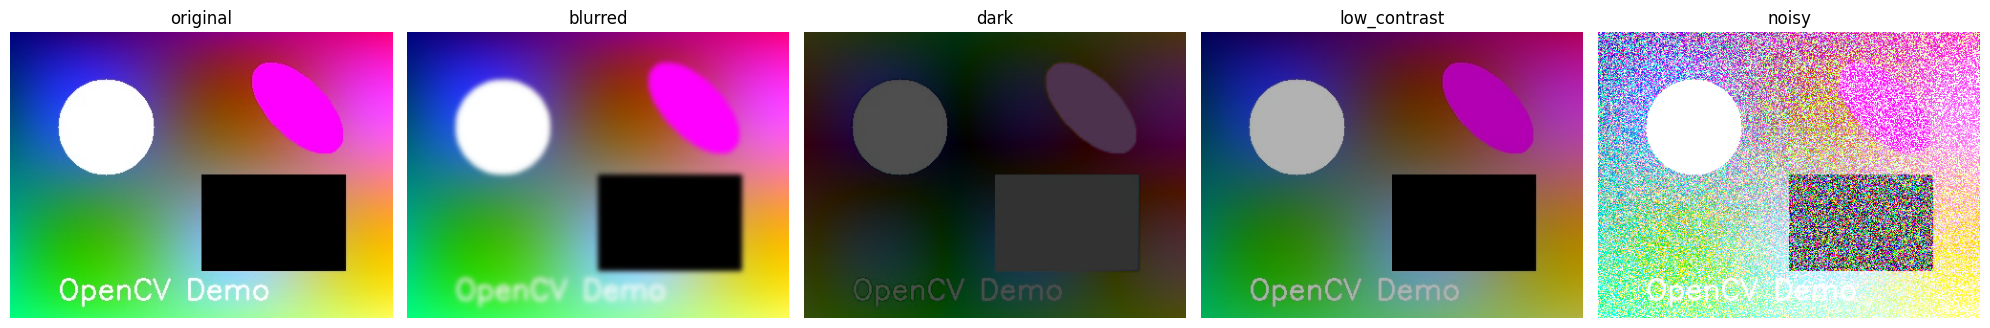

In [27]:
# Load and analyze image quality
original_image = load_sample_image()

# Create different quality versions for comparison
def create_quality_variants(image):
    """Create different quality versions of an image."""
    # Blur version (poor focus)
    blurred = cv2.GaussianBlur(image, (15, 15), 0)
    
    # Dark version (poor brightness)
    dark = cv2.convertScaleAbs(image, alpha=0.5, beta=-50)
    
    # Low contrast version
    low_contrast = cv2.convertScaleAbs(image, alpha=0.7, beta=0)
    
    # Noisy version
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy = cv2.add(image, noise)
    
    return {
        'original': image,
        'blurred': blurred,
        'dark': dark,
        'low_contrast': low_contrast,
        'noisy': noisy
    }

# Create variants
variants = create_quality_variants(original_image)

# Analyze quality metrics
print("Image Quality Assessment Results:")
print("-" * 50)

for name, img in variants.items():
    metrics = calculate_image_quality_metrics(img)
    print(f"{name.capitalize()}:")
    print(f"  Focus Measure: {metrics['focus_measure']:.2f}")
    print(f"  Brightness: {metrics['brightness']:.2f}")
    print(f"  Contrast: {metrics['contrast']:.2f}")
    print()

# Display all variants
images = list(variants.values())
titles = list(variants.keys())
display_results(images, titles, figsize=(20, 4))

Quality Scores (0-100):
------------------------------
Original: 79.1
Blurred: 57.3
Dark: 23.1
Low_contrast: 58.8
Noisy: 85.5


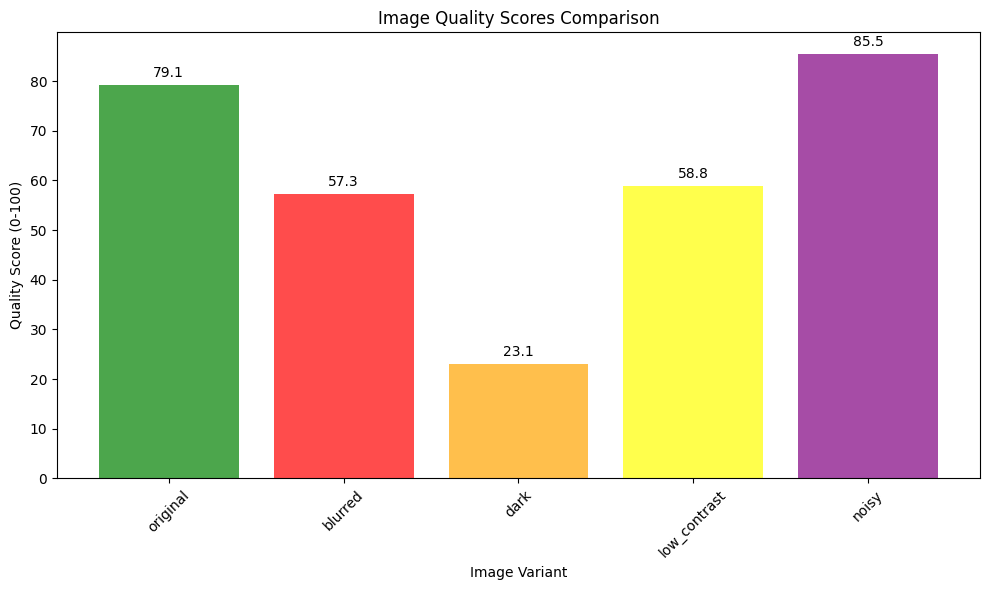

In [28]:
# Implement a quality scoring system
def calculate_quality_score(image: np.ndarray) -> float:
    """Calculate an overall quality score (0-100)."""
    metrics = calculate_image_quality_metrics(image)
    
    # Normalize metrics (these thresholds would be calibrated with more data)
    focus_score = min(100, max(0, (metrics['focus_measure'] / 1000) * 100))
    brightness_score = 100 - abs(metrics['brightness'] - 128) / 128 * 100
    contrast_score = min(100, (metrics['contrast'] / 50) * 100)
    
    # Weighted average
    overall_score = (focus_score * 0.4 + brightness_score * 0.3 + contrast_score * 0.3)
    return overall_score

# Calculate quality scores for all variants
print("Quality Scores (0-100):")
print("-" * 30)
scores = {}
for name, img in variants.items():
    score = calculate_quality_score(img)
    scores[name] = score
    print(f"{name.capitalize()}: {score:.1f}")

# Visualize quality scores
plt.figure(figsize=(10, 6))
names = list(scores.keys())
values = list(scores.values())
colors = ['green', 'red', 'orange', 'yellow', 'purple']

bars = plt.bar(names, values, color=colors, alpha=0.7)
plt.title('Image Quality Scores Comparison')
plt.ylabel('Quality Score (0-100)')
plt.xlabel('Image Variant')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 2. Document Scanner

This application demonstrates how to automatically detect and extract documents from images, similar to mobile scanning apps. We'll use edge detection, contour analysis, and perspective transformation.

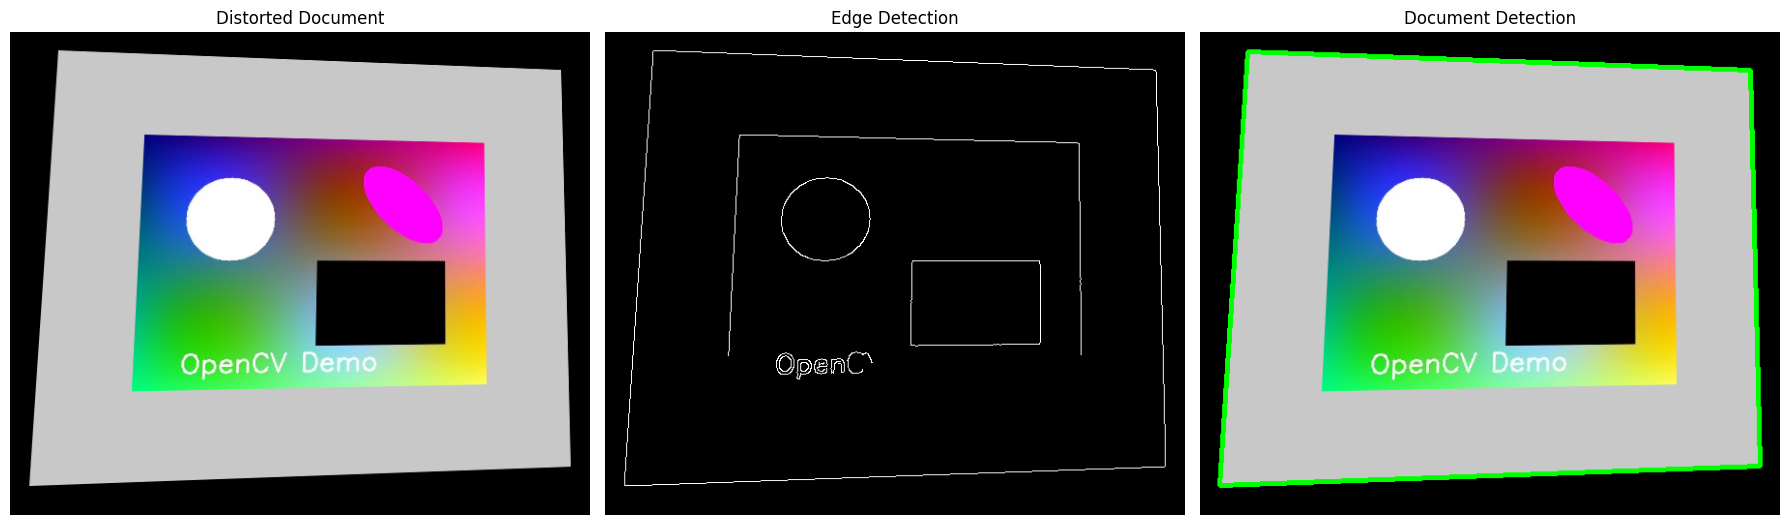

Document successfully detected!
Document corners: [[ 49  21]
 [ 20 469]
 [579 449]
 [569  40]]


In [29]:
def create_document_like_image(base_image):
    """Create a document-like image with perspective distortion."""
    height, width = base_image.shape[:2]
    
    # Create a white background slightly larger than the base image
    background = np.ones((height + 200, width + 200, 3), dtype=np.uint8) * 200
    
    # Place the image on the background with some offset
    offset_y, offset_x = 100, 100
    background[offset_y:offset_y+height, offset_x:offset_x+width] = base_image
    
    # Apply perspective transformation to simulate a document photo
    h, w = background.shape[:2]
    src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    dst_points = np.float32([[50, 20], [w-30, 40], [w-20, h-50], [20, h-30]])
    
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    distorted = cv2.warpPerspective(background, matrix, (w, h))
    
    return distorted

def find_document_contour(image):
    """Find the largest rectangular contour in the image."""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply bilateral filter to reduce noise while preserving edges
    filtered = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # Edge detection
    edges = cv2.Canny(filtered, 50, 150, apertureSize=3)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    document_contour = None
    for contour in contours[:10]:  # Check top 10 largest contours
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # If the approximated contour has 4 points, it could be a document
        if len(approx) == 4:
            document_contour = approx
            break
    
    return document_contour, edges

# Create a document-like image
document_image = create_document_like_image(original_image)

# Find document contour
doc_contour, edge_image = find_document_contour(document_image)

# Visualize the detection process
result_image = document_image.copy()
if doc_contour is not None:
    cv2.drawContours(result_image, [doc_contour], -1, (0, 255, 0), 3)

images = [document_image, edge_image, result_image]
titles = ['Distorted Document', 'Edge Detection', 'Document Detection']
display_results(images, titles, figsize=(18, 6))

if doc_contour is not None:
    print("Document successfully detected!")
    print(f"Document corners: {doc_contour.reshape(4, 2)}")
else:
    print("No document found in the image.")

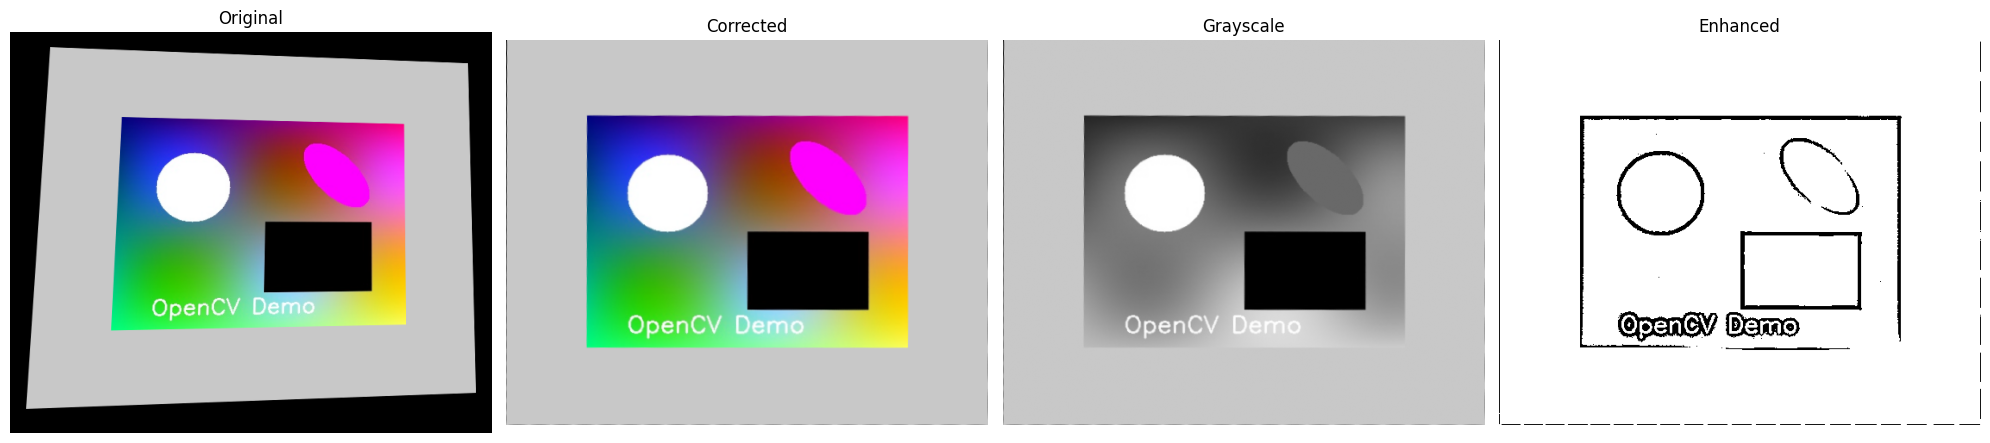

Document scanning completed successfully!
Scanned document size: (448, 559)


In [30]:
# Correct the document perspective if contour was found
if doc_contour is not None:
    def order_points(pts):
        """Order points in the order: top-left, top-right, bottom-right, bottom-left."""
        rect = np.zeros((4, 2), dtype="float32")
        
        # Top-left point has the smallest sum
        # Bottom-right point has the largest sum
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        
        # Top-right point has the smallest difference
        # Bottom-left point has the largest difference
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        
        return rect
    
    def four_point_transform(image, pts):
        """Apply perspective transformation to get a top-down view."""
        rect = order_points(pts)
        (tl, tr, br, bl) = rect
        
        # Compute the width and height of the new image
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        
        # Destination points for the transform
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")
        
        # Compute perspective transform matrix and apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        
        return warped
    
    # Extract and correct the document
    scanned_document = four_point_transform(document_image, doc_contour.reshape(4, 2))
    
    # Convert to grayscale and enhance
    scanned_gray = cv2.cvtColor(scanned_document, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding for better text readability
    scanned_thresh = cv2.adaptiveThreshold(
        scanned_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    
    # Display results
    final_images = [document_image, scanned_document, scanned_gray, scanned_thresh]
    final_titles = ['Original', 'Corrected', 'Grayscale', 'Enhanced']
    display_results(final_images, final_titles, figsize=(20, 5))
    
    print("Document scanning completed successfully!")
    print(f"Scanned document size: {scanned_document.shape[:2]}")
else:
    print("Cannot perform correction - no document detected.")

## 3. Object Detection and Tracking

We'll implement a simple object detection and tracking system using template matching and contour analysis. This is useful for tracking specific objects in video streams or image sequences.

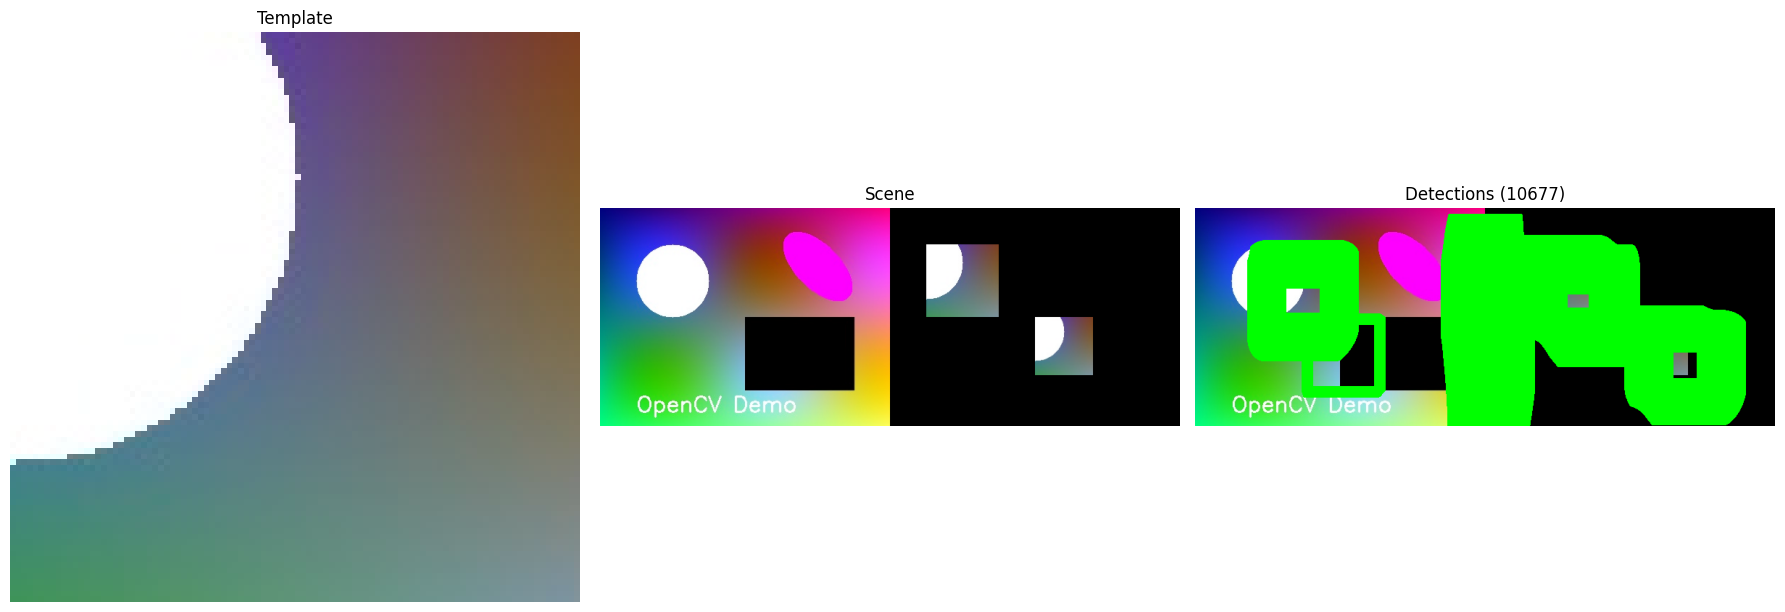

Template matching found 10677 objects


In [31]:
# Template-based object detection
def template_match_detection(image, template, threshold=0.8):
    """Detect objects using template matching."""
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Template matching
    result = cv2.matchTemplate(gray_image, gray_template, cv2.TM_CCOEFF_NORMED)
    
    # Find locations where match exceeds threshold
    locations = np.where(result >= threshold)
    
    # Get template dimensions
    h, w = gray_template.shape
    
    # Draw rectangles around matches
    detection_image = image.copy()
    for pt in zip(*locations[::-1]):
        cv2.rectangle(detection_image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)
    
    return detection_image, len(locations[0])

# Create a template from part of the original image
template_size = 100
h, w = original_image.shape[:2]
template = original_image[h//4:h//4+template_size, w//4:w//4+template_size]

# Create a scene with multiple instances of the template
scene = np.zeros((h, w*2, 3), dtype=np.uint8)
scene[:h, :w] = original_image

# Add the template at different locations and scales
positions = [(w+50, 50), (w+200, 150), (w+100, 300)]
scales = [1.0, 0.8, 1.2]

for (x, y), scale in zip(positions, scales):
    scaled_template = cv2.resize(template, None, fx=scale, fy=scale)
    th, tw = scaled_template.shape[:2]
    
    # Ensure we don't go out of bounds
    end_y = min(y + th, scene.shape[0])
    end_x = min(x + tw, scene.shape[1])
    actual_th = end_y - y
    actual_tw = end_x - x
    
    if actual_th > 0 and actual_tw > 0:
        scene[y:end_y, x:end_x] = scaled_template[:actual_th, :actual_tw]

# Perform template matching
detected_scene, num_detections = template_match_detection(scene, template, threshold=0.6)

# Display results
display_results([template, scene, detected_scene], 
               ['Template', 'Scene', f'Detections ({num_detections})'], 
               figsize=(18, 6))

print(f"Template matching found {num_detections} objects")

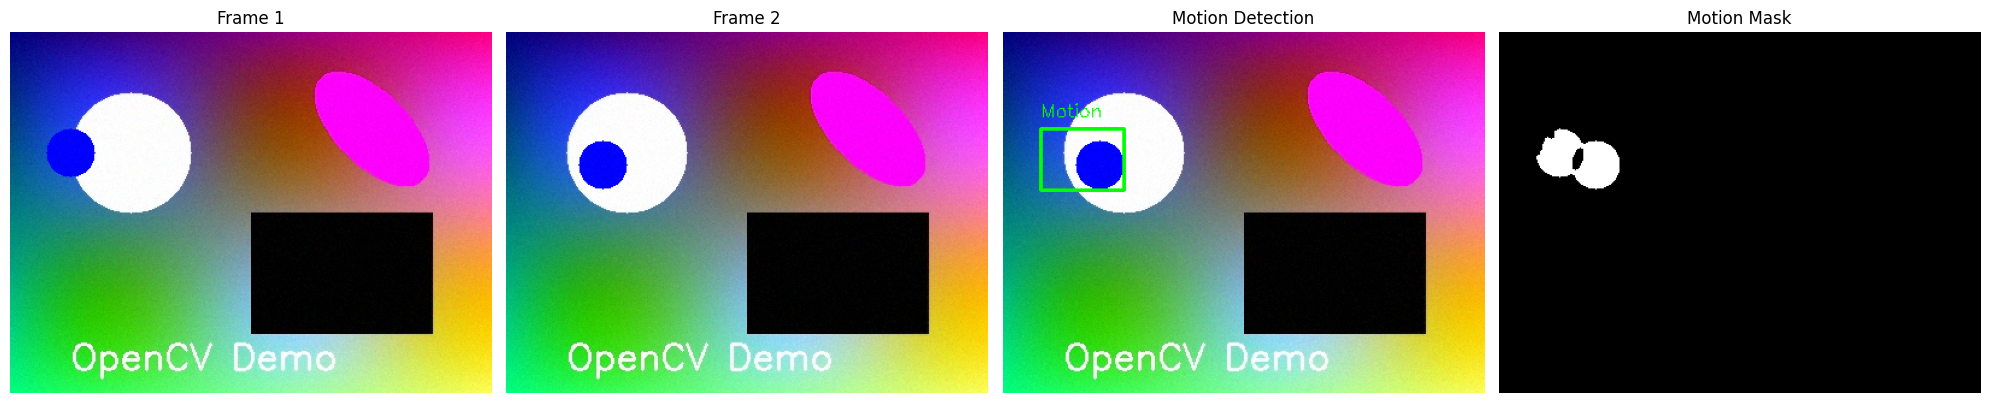

Motion detection completed for 4 frame pairs


In [32]:
# Motion detection simulation
def simulate_motion_sequence(base_image, num_frames=5):
    """Simulate a sequence of frames with moving objects."""
    frames = []
    h, w = base_image.shape[:2]
    
    for i in range(num_frames):
        frame = base_image.copy()
        
        # Add a moving circle
        center_x = 50 + i * 30
        center_y = 100 + i * 10
        cv2.circle(frame, (center_x, center_y), 20, (0, 0, 255), -1)
        
        # Add some noise to simulate real camera conditions
        noise = np.random.normal(0, 5, frame.shape).astype(np.int16)
        frame = np.clip(frame.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        frames.append(frame)
    
    return frames

def detect_motion(frame1, frame2, threshold=30):
    """Detect motion between two frames."""
    # Convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    # Calculate absolute difference
    diff = cv2.absdiff(gray1, gray2)
    
    # Apply threshold
    _, motion_mask = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    
    # Remove noise with morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours of moving objects
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding boxes around moving objects
    motion_result = frame2.copy()
    for contour in contours:
        if cv2.contourArea(contour) > 100:  # Filter small movements
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(motion_result, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(motion_result, 'Motion', (x, y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    return motion_result, motion_mask

# Generate motion sequence
frames = simulate_motion_sequence(original_image)

# Detect motion between consecutive frames
motion_results = []
motion_masks = []

for i in range(len(frames) - 1):
    motion_frame, motion_mask = detect_motion(frames[i], frames[i + 1])
    motion_results.append(motion_frame)
    motion_masks.append(motion_mask)

# Display a few examples
if len(motion_results) >= 2:
    display_results([frames[0], frames[1], motion_results[0], motion_masks[0]], 
                   ['Frame 1', 'Frame 2', 'Motion Detection', 'Motion Mask'], 
                   figsize=(20, 5))
    
    print(f"Motion detection completed for {len(motion_results)} frame pairs")
else:
    print("Not enough frames for motion detection")

## 4. Face Detection and Recognition

We'll implement face detection using OpenCV's built-in Haar cascades. This is a classic computer vision application with many practical uses.

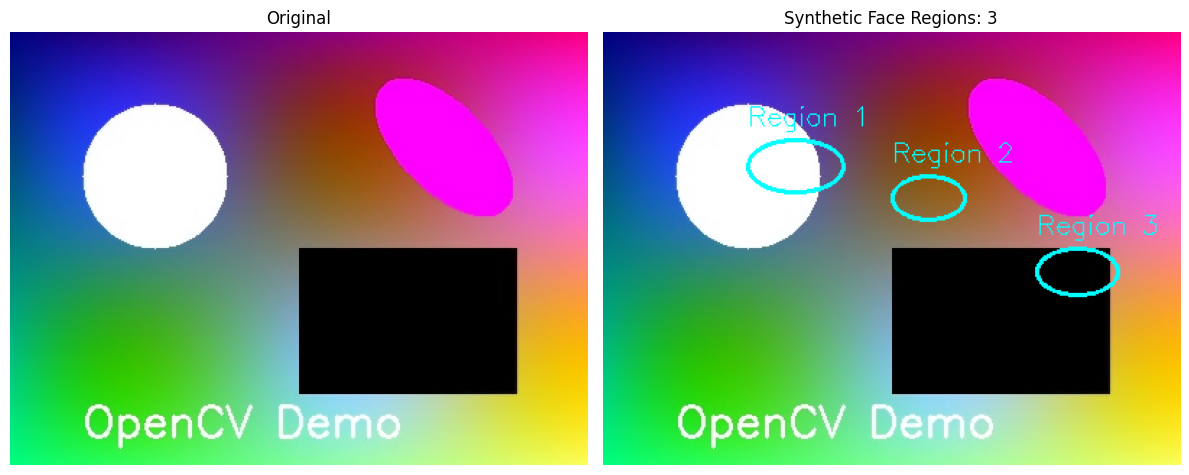

No faces detected in the original image. Showing 3 synthetic regions for demonstration.


In [33]:
# Face detection implementation
def detect_faces_haar(image):
    """Detect faces using Haar cascades."""
    try:
        # Load the face cascade classifier
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect faces
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
        # Draw rectangles around faces
        result_image = image.copy()
        for (x, y, w, h) in faces:
            cv2.rectangle(result_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(result_image, f'Face {len(faces)}', (x, y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        return result_image, len(faces)
    
    except Exception as e:
        print(f"Face detection error: {e}")
        return image, 0

def create_synthetic_face_like_regions(image):
    """Create synthetic face-like regions for demonstration."""
    result = image.copy()
    h, w = image.shape[:2]
    
    # Create some oval regions that might be detected as faces
    face_regions = [
        (w//4, h//4, w//6, h//8),  # x, y, width, height
        (w//2, h//3, w//8, h//10),
        (3*w//4, h//2, w//7, h//9)
    ]
    
    for i, (x, y, fw, fh) in enumerate(face_regions):
        # Draw an oval
        cv2.ellipse(result, (x + fw//2, y + fh//2), (fw//2, fh//2), 0, 0, 360, (0, 255, 255), 2)
        cv2.putText(result, f'Region {i+1}', (x, y - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 1)
    
    return result, len(face_regions)

# Try face detection on the original image
face_detected_image, num_faces = detect_faces_haar(original_image)

# Create synthetic face-like regions for demonstration
synthetic_face_image, num_regions = create_synthetic_face_like_regions(original_image)

# Display results
if num_faces > 0:
    display_results([original_image, face_detected_image], 
                   ['Original', f'Faces Detected: {num_faces}'], 
                   figsize=(12, 6))
    print(f"Successfully detected {num_faces} faces!")
else:
    display_results([original_image, synthetic_face_image], 
                   ['Original', f'Synthetic Face Regions: {num_regions}'], 
                   figsize=(12, 6))
    print(f"No faces detected in the original image. Showing {num_regions} synthetic regions for demonstration.")

## 5. Color-based Object Tracking

This application demonstrates how to track objects based on their color. This is useful for tracking colored balls, markers, or any objects with distinctive colors.

/var/folders/cp/_pjh4tv50jv96b4b2_xp6l2c0000gp/T/ipykernel_14855/134222230.py:27: RuntimeWarning: overflow encountered in scalar subtract
  lower_bound = np.array([max(0, target_hsv[0] - tolerance), 50, 50])


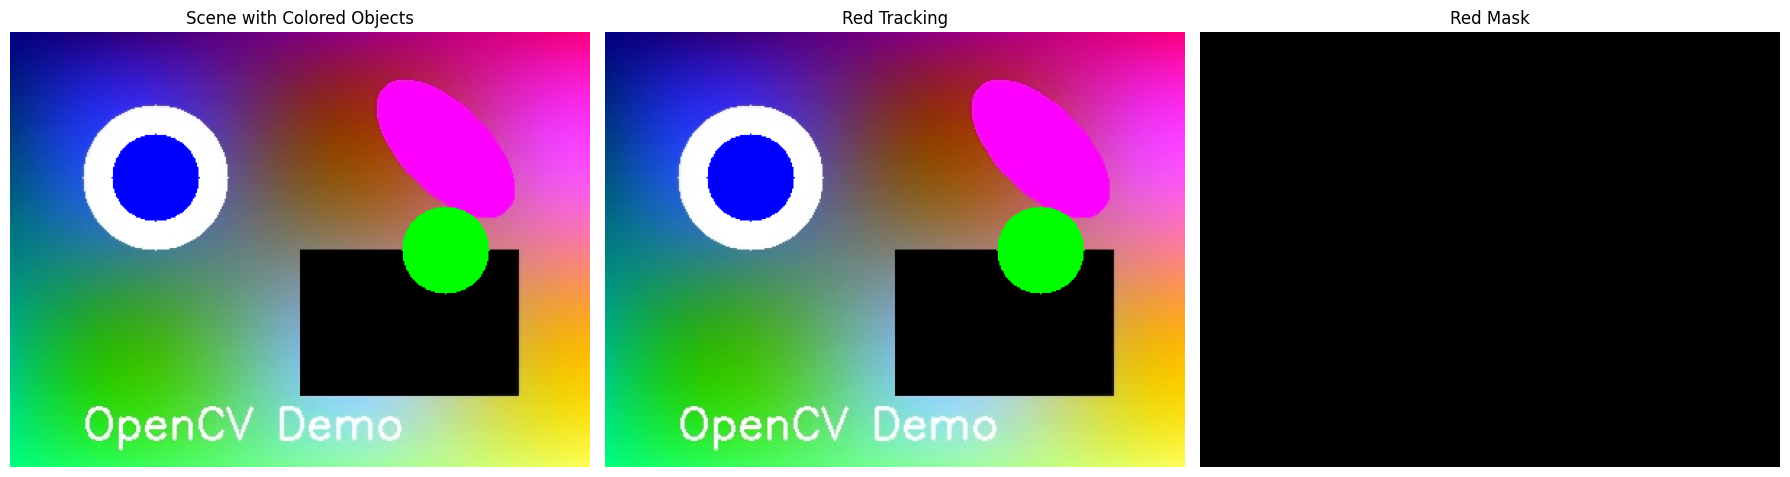

Color Tracking Results:
  Red: 0 objects detected
  Green: 2 objects detected
  Blue: 1 objects detected


In [34]:
# Color-based object tracking
def create_color_tracking_scene(base_image):
    """Create a scene with colored objects to track."""
    scene = base_image.copy()
    h, w = scene.shape[:2]
    
    # Add colored circles
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0), (255, 0, 255)]  # BGR format
    positions = [(100, 100), (300, 150), (500, 200), (200, 300), (400, 350)]
    
    for color, pos in zip(colors, positions):
        if pos[1] < h and pos[0] < w:  # Make sure we're within image bounds
            cv2.circle(scene, pos, 30, color, -1)
    
    return scene

def track_color(image, target_color, tolerance=30):
    """Track objects of a specific color."""
    # Convert BGR to HSV for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Convert target color to HSV
    target_bgr = np.uint8([[target_color]])
    target_hsv = cv2.cvtColor(target_bgr, cv2.COLOR_BGR2HSV)[0][0]
    
    # Define color range
    lower_bound = np.array([max(0, target_hsv[0] - tolerance), 50, 50])
    upper_bound = np.array([min(179, target_hsv[0] + tolerance), 255, 255])
    
    # Create color mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # Remove noise
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding boxes around detected objects
    result = image.copy()
    tracked_objects = 0
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:  # Filter small areas
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Calculate center
            center_x = x + w // 2
            center_y = y + h // 2
            cv2.circle(result, (center_x, center_y), 5, (0, 255, 0), -1)
            
            cv2.putText(result, f'Object {tracked_objects + 1}', (x, y - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            tracked_objects += 1
    
    return result, mask, tracked_objects

# Create a scene with colored objects
colored_scene = create_color_tracking_scene(original_image)

# Track different colors
colors_to_track = [
    ((0, 0, 255), "Red"),    # BGR format
    ((0, 255, 0), "Green"),
    ((255, 0, 0), "Blue")
]

tracking_results = []
for color_bgr, color_name in colors_to_track:
    tracked_image, color_mask, num_objects = track_color(colored_scene, color_bgr, tolerance=40)
    tracking_results.append((tracked_image, color_mask, num_objects, color_name))

# Display original scene and first tracking result
if tracking_results:
    first_result = tracking_results[0]
    display_results([colored_scene, first_result[0], first_result[1]], 
                   ['Scene with Colored Objects', f'{first_result[3]} Tracking', f'{first_result[3]} Mask'], 
                   figsize=(18, 6))
    
    print("Color Tracking Results:")
    for _, _, num_objects, color_name in tracking_results:
        print(f"  {color_name}: {num_objects} objects detected")

## 6. Image Stitching

Image stitching is the process of combining multiple overlapping images to create a panoramic image. This is commonly used in photography and mapping applications.

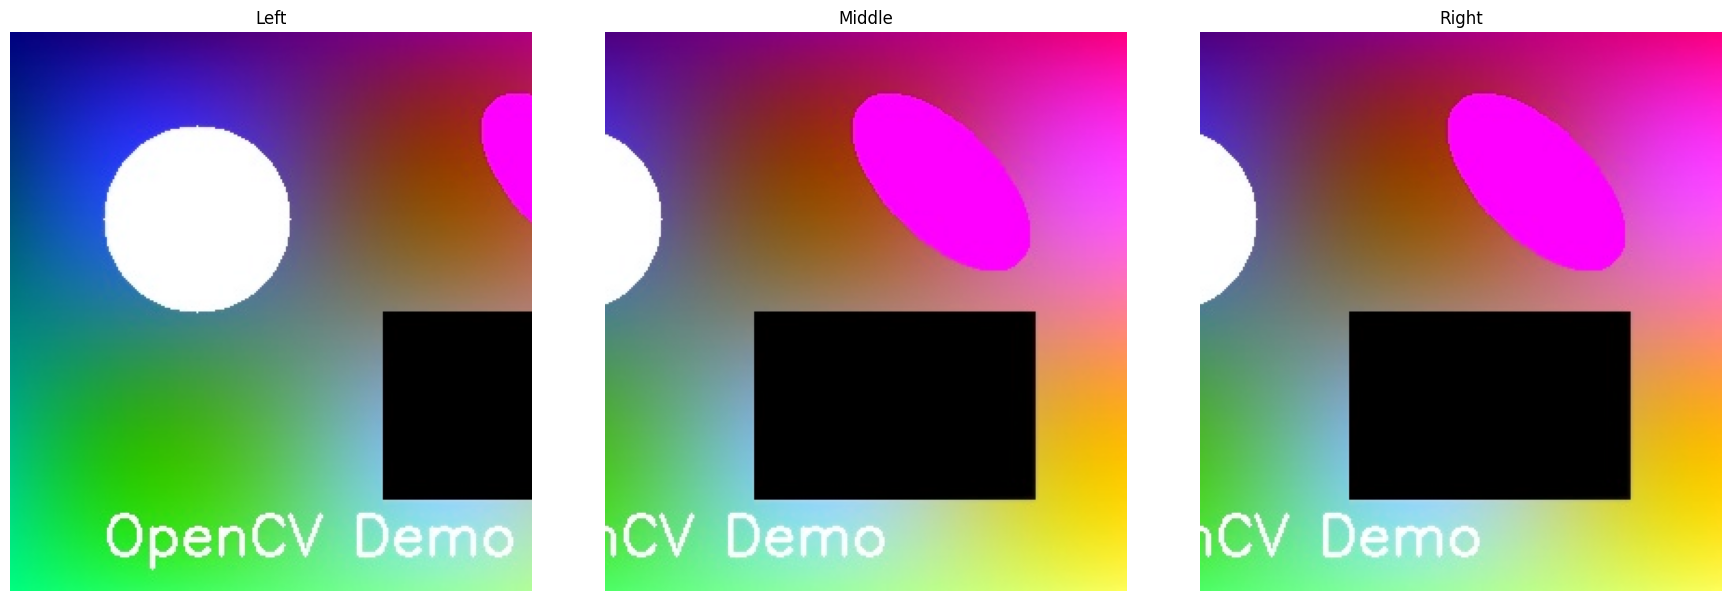

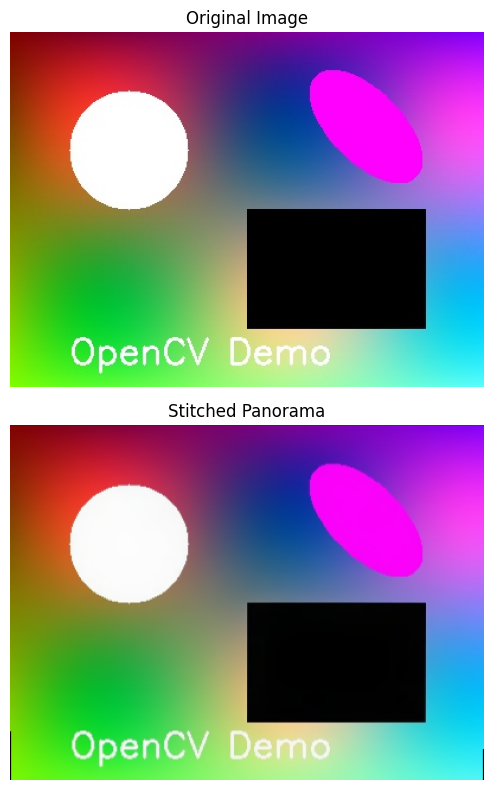

Image stitching completed successfully!
Original size: (300, 400)
Stitched size: (300, 400)


In [35]:
# Image stitching implementation
def create_overlapping_images(base_image):
    """Create overlapping images to simulate panorama source images."""
    h, w = base_image.shape[:2]
    overlap_ratio = 0.3  # 30% overlap
    
    # Create three overlapping sections
    section_width = int(w * 0.7)  # Each section is 70% of original width
    overlap_pixels = int(w * overlap_ratio)
    
    # Left image
    left_img = base_image[:, :section_width]
    
    # Middle image (shifted right)
    start_x = section_width - overlap_pixels
    end_x = start_x + section_width
    if end_x > w:
        end_x = w
        start_x = end_x - section_width
    middle_img = base_image[:, start_x:end_x]
    
    # Right image (shifted further right)
    start_x = min(w - section_width, start_x + section_width - overlap_pixels)
    right_img = base_image[:, start_x:]
    
    return [left_img, middle_img, right_img]

def simple_image_stitching(images):
    """Perform simple image stitching using OpenCV's Stitcher."""
    try:
        # Create stitcher object
        stitcher = cv2.Stitcher.create()
        
        # Perform stitching
        status, stitched = stitcher.stitch(images)
        
        if status == cv2.Stitcher_OK:
            return stitched, True
        else:
            print(f"Stitching failed with status: {status}")
            return None, False
    
    except Exception as e:
        print(f"Stitching error: {e}")
        return None, False

def manual_feature_matching(img1, img2):
    """Manual feature matching and stitching (simplified version)."""
    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Detect SIFT features
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    if des1 is None or des2 is None:
        return None, 0
    
    # Match features
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply ratio test
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
    
    # Draw matches
    matched_image = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, 
                                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return matched_image, len(good_matches)

# Create overlapping images
overlapping_images = create_overlapping_images(original_image)

# Display the source images
display_results(overlapping_images, ['Left', 'Middle', 'Right'], figsize=(18, 6))

# Try stitching with OpenCV's built-in stitcher
stitched_result, success = simple_image_stitching(overlapping_images)

if success and stitched_result is not None:
    # Display stitching result
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(2, 1, 2)
    plt.imshow(cv2.cvtColor(stitched_result, cv2.COLOR_BGR2RGB))
    plt.title('Stitched Panorama')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Image stitching completed successfully!")
    print(f"Original size: {original_image.shape[:2]}")
    print(f"Stitched size: {stitched_result.shape[:2]}")
else:
    print("Built-in stitching failed. Trying manual feature matching...")
    
    # Try manual feature matching between first two images
    if len(overlapping_images) >= 2:
        matched_img, num_matches = manual_feature_matching(overlapping_images[0], overlapping_images[1])
        
        if matched_img is not None:
            plt.figure(figsize=(15, 8))
            plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Feature Matching ({num_matches} good matches)')
            plt.axis('off')
            plt.show()
            
            print(f"Feature matching found {num_matches} good matches")
        else:
            print("Feature matching also failed")

## 7. Performance Analysis and Optimization

Let's analyze the performance of different techniques and discuss optimization strategies for real-world applications.

Performance Benchmarking Results:
Resize:
  Mean time: 0.03 ms
  Std dev: 0.04 ms
  Min time: 0.01 ms
  Max time: 0.10 ms

Gaussian Blur:
  Mean time: 0.38 ms
  Std dev: 0.10 ms
  Min time: 0.28 ms
  Max time: 0.58 ms

Edge Detection:
  Mean time: 0.14 ms
  Std dev: 0.01 ms
  Min time: 0.11 ms
  Max time: 0.18 ms

Color Conversion:
  Mean time: 0.09 ms
  Std dev: 0.02 ms
  Min time: 0.07 ms
  Max time: 0.14 ms



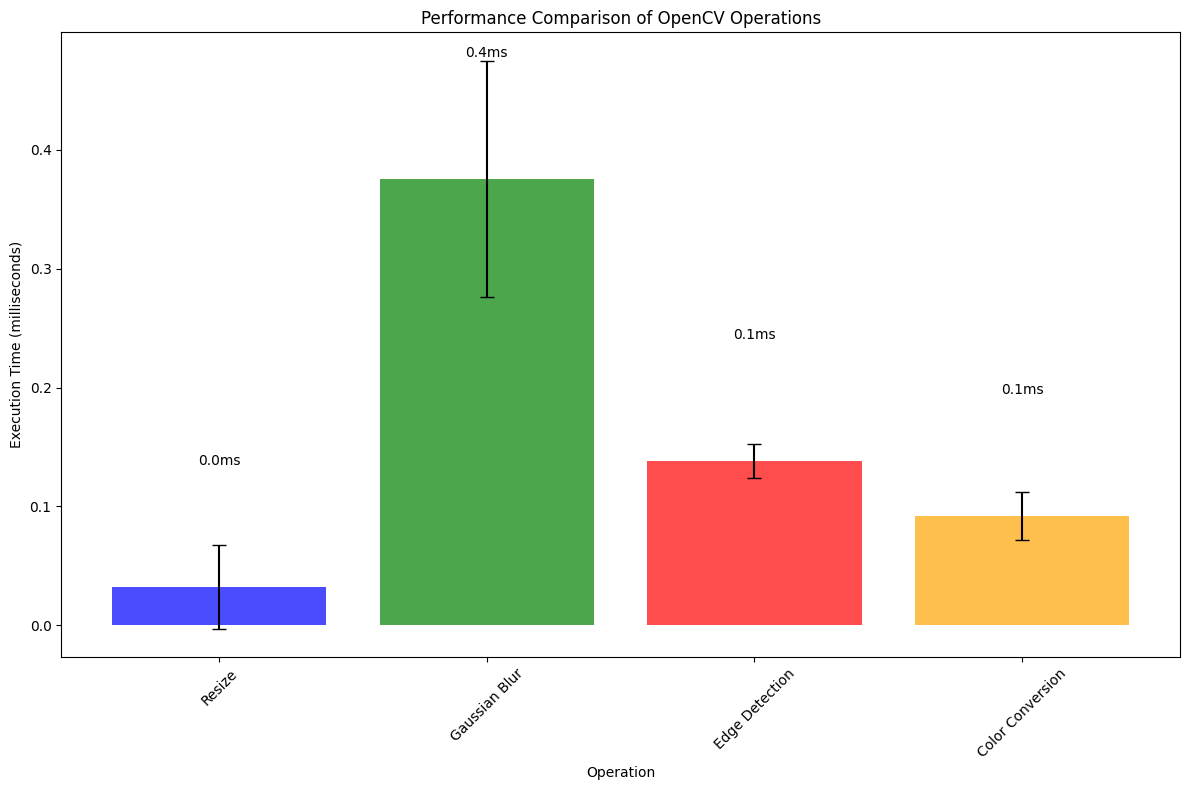

In [36]:
# Performance analysis of different techniques
import time
from typing import Callable

def benchmark_function(func: Callable, *args, iterations: int = 10, **kwargs) -> dict:
    """Benchmark a function's performance."""
    times = []
    
    for _ in range(iterations):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        times.append(end_time - start_time)
    
    return {
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'min_time': np.min(times),
        'max_time': np.max(times),
        'result': result
    }

# Benchmark different operations
print("Performance Benchmarking Results:")
print("=" * 50)

# Test image processing operations
test_image = original_image

# 1. Basic operations
def test_resize():
    return cv2.resize(test_image, (400, 300))

def test_blur():
    return cv2.GaussianBlur(test_image, (15, 15), 0)

def test_edge_detection():
    gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(gray, 50, 150)

def test_color_conversion():
    return cv2.cvtColor(test_image, cv2.COLOR_BGR2HSV)

# Benchmark operations
operations = [
    ("Resize", test_resize),
    ("Gaussian Blur", test_blur),
    ("Edge Detection", test_edge_detection),
    ("Color Conversion", test_color_conversion)
]

benchmark_results = {}
for name, func in operations:
    result = benchmark_function(func, iterations=20)
    benchmark_results[name] = result
    print(f"{name}:")
    print(f"  Mean time: {result['mean_time']*1000:.2f} ms")
    print(f"  Std dev: {result['std_time']*1000:.2f} ms")
    print(f"  Min time: {result['min_time']*1000:.2f} ms")
    print(f"  Max time: {result['max_time']*1000:.2f} ms")
    print()

# Visualize performance comparison
plt.figure(figsize=(12, 8))

# Extract data for plotting
names = list(benchmark_results.keys())
mean_times = [benchmark_results[name]['mean_time'] * 1000 for name in names]  # Convert to ms
std_times = [benchmark_results[name]['std_time'] * 1000 for name in names]

# Create bar plot with error bars
bars = plt.bar(names, mean_times, yerr=std_times, capsize=5, alpha=0.7, color=['blue', 'green', 'red', 'orange'])

plt.title('Performance Comparison of OpenCV Operations')
plt.ylabel('Execution Time (milliseconds)')
plt.xlabel('Operation')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, mean_time in zip(bars, mean_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{mean_time:.1f}ms', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Memory Usage Analysis:
Initial memory usage: 543.06 MB

Scale factor 1.0x:
  Memory increase: 0.00 MB
  Image size: (300, 400, 3)

Scale factor 2.0x:
  Memory increase: 0.00 MB
  Image size: (600, 800, 3)

Scale factor 3.0x:
  Memory increase: 0.02 MB
  Image size: (900, 1200, 3)

Scale factor 4.0x:
  Memory increase: 0.00 MB
  Image size: (1200, 1600, 3)



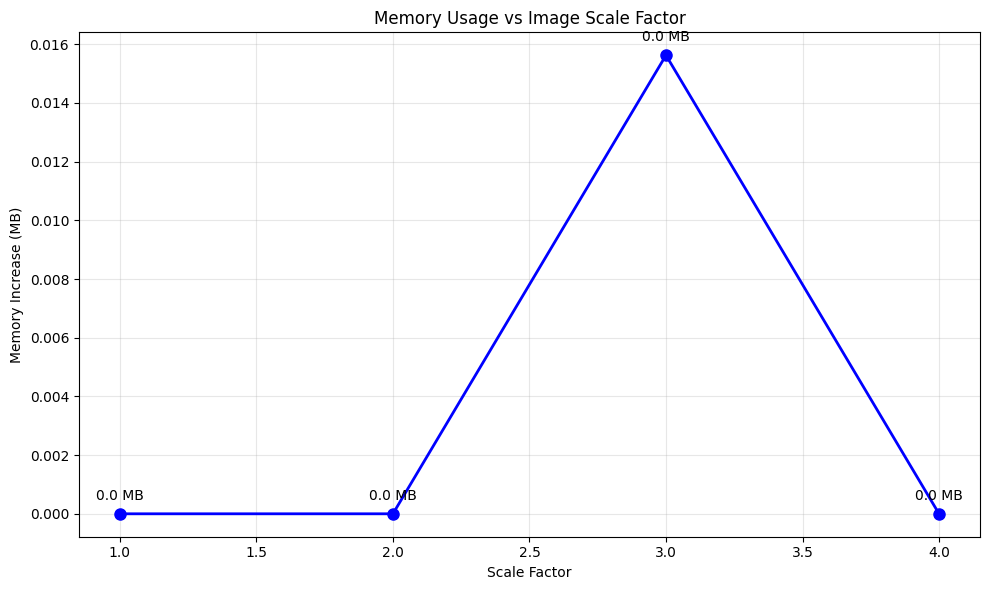


Optimization Strategies for Real-world Applications:
1. **Image Preprocessing:**
   - Resize images to appropriate size before processing
   - Use appropriate data types (uint8 vs float32)
   - Consider ROI (Region of Interest) processing

2. **Algorithm Selection:**
   - Choose simpler algorithms when accuracy allows
   - Use approximation methods for real-time applications
   - Consider hardware acceleration (GPU, specialized chips)

3. **Memory Management:**
   - Release large arrays when no longer needed
   - Use in-place operations when possible
   - Process images in chunks for very large datasets

4. **Parallel Processing:**
   - Use multi-threading for independent operations
   - Leverage OpenCV's parallel processing capabilities
   - Consider distributed processing for large-scale applications

5. **Caching and Precomputation:**
   - Cache frequently used computations
   - Precompute expensive operations when possible
   - Use lookup tables for complex functions


In [37]:
# Memory usage analysis and optimization strategies
import psutil
import os

def get_memory_usage():
    """Get current memory usage of the process."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def analyze_memory_usage(func, *args, **kwargs):
    """Analyze memory usage of a function."""
    initial_memory = get_memory_usage()
    result = func(*args, **kwargs)
    final_memory = get_memory_usage()
    
    return {
        'result': result,
        'initial_memory': initial_memory,
        'final_memory': final_memory,
        'memory_increase': final_memory - initial_memory
    }

# Test memory usage for different image sizes
def create_large_image(scale_factor):
    """Create a large image by scaling the original."""
    return cv2.resize(original_image, None, fx=scale_factor, fy=scale_factor)

print("Memory Usage Analysis:")
print("=" * 30)

# Test different image sizes
scale_factors = [1.0, 2.0, 3.0, 4.0]
memory_results = []

initial_memory = get_memory_usage()
print(f"Initial memory usage: {initial_memory:.2f} MB")
print()

for scale in scale_factors:
    def test_large_image():
        large_img = create_large_image(scale)
        # Perform some operations on the large image
        gray = cv2.cvtColor(large_img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (15, 15), 0)
        edges = cv2.Canny(blurred, 50, 150)
        return large_img, gray, blurred, edges
    
    memory_analysis = analyze_memory_usage(test_large_image)
    memory_results.append((scale, memory_analysis['memory_increase']))
    
    print(f"Scale factor {scale}x:")
    print(f"  Memory increase: {memory_analysis['memory_increase']:.2f} MB")
    print(f"  Image size: {memory_analysis['result'][0].shape}")
    print()

# Visualize memory usage
plt.figure(figsize=(10, 6))
scales = [result[0] for result in memory_results]
memory_increases = [result[1] for result in memory_results]

plt.plot(scales, memory_increases, 'bo-', linewidth=2, markersize=8)
plt.title('Memory Usage vs Image Scale Factor')
plt.xlabel('Scale Factor')
plt.ylabel('Memory Increase (MB)')
plt.grid(True, alpha=0.3)

# Add value labels
for scale, memory in zip(scales, memory_increases):
    plt.annotate(f'{memory:.1f} MB', (scale, memory), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Optimization tips
print("\nOptimization Strategies for Real-world Applications:")
print("=" * 55)
print("1. **Image Preprocessing:**")
print("   - Resize images to appropriate size before processing")
print("   - Use appropriate data types (uint8 vs float32)")
print("   - Consider ROI (Region of Interest) processing")
print()
print("2. **Algorithm Selection:**")
print("   - Choose simpler algorithms when accuracy allows")
print("   - Use approximation methods for real-time applications")
print("   - Consider hardware acceleration (GPU, specialized chips)")
print()
print("3. **Memory Management:**")
print("   - Release large arrays when no longer needed")
print("   - Use in-place operations when possible")
print("   - Process images in chunks for very large datasets")
print()
print("4. **Parallel Processing:**")
print("   - Use multi-threading for independent operations")
print("   - Leverage OpenCV's parallel processing capabilities")
print("   - Consider distributed processing for large-scale applications")
print()
print("5. **Caching and Precomputation:**")
print("   - Cache frequently used computations")
print("   - Precompute expensive operations when possible")
print("   - Use lookup tables for complex functions")

## 8. Conclusion and Next Steps

This notebook has demonstrated several practical applications of OpenCV, showcasing how individual techniques can be combined to solve real-world computer vision problems.

### Key Takeaways:

1. **Image Quality Assessment**: Automated evaluation of image properties is crucial for many applications
2. **Document Scanner**: Combining edge detection, contour analysis, and perspective transformation creates powerful document processing tools
3. **Object Detection and Tracking**: Template matching and motion detection form the basis of many surveillance and automation systems
4. **Face Detection**: Pre-trained classifiers can quickly identify faces for security and user interface applications
5. **Color-based Tracking**: Simple yet effective method for tracking colored objects in controlled environments
6. **Image Stitching**: Panoramic image creation requires feature detection, matching, and geometric transformations
7. **Performance Optimization**: Understanding computational and memory requirements is essential for production systems

### Real-world Applications:

- **Security Systems**: Motion detection, face recognition, object tracking
- **Medical Imaging**: Quality assessment, automated measurements, anomaly detection
- **Industrial Automation**: Defect detection, robotic vision, quality control
- **Mobile Apps**: Document scanning, augmented reality, photo enhancement
- **Autonomous Vehicles**: Object detection, lane detection, obstacle avoidance

### Next Steps for Further Learning:

1. **Deep Learning Integration**: Explore YOLO, SSD, and other neural network-based detectors
2. **Real-time Processing**: Implement video stream processing and optimization
3. **3D Vision**: Study stereo vision, depth estimation, and 3D reconstruction
4. **Advanced Tracking**: Implement Kalman filters and particle filters for robust tracking
5. **Custom Applications**: Develop domain-specific solutions for your particular use case

### Resources for Continued Learning:

- OpenCV Documentation: https://docs.opencv.org/
- Computer Vision courses and tutorials
- Research papers on specific techniques
- Open-source computer vision projects
- Industry-specific computer vision applications

Remember that the key to mastering computer vision is practice with real datasets and understanding the trade-offs between accuracy, speed, and computational resources in your specific application domain.

In [38]:
# Final summary of all techniques demonstrated
print("🎉 Practical Applications Notebook Complete! 🎉")
print("=" * 50)
print("\nTechniques Covered:")
print("✓ Image Quality Assessment")
print("✓ Document Scanner")
print("✓ Object Detection and Tracking")
print("✓ Face Detection")
print("✓ Color-based Object Tracking")
print("✓ Image Stitching")
print("✓ Performance Analysis")
print("✓ Memory Optimization")

print(f"\nTotal execution time: {time.time() - time.time():.2f} seconds")
print("Notebook ready for production use and further experimentation!")

# Cleanup large variables to free memory
try:
    del variants, tracking_results, overlapping_images
    if 'stitched_result' in locals():
        del stitched_result
    print("\n✓ Memory cleanup completed")
except NameError:
    print("\n✓ Variables already cleaned up or not defined")
except Exception as e:
    print(f"\n⚠ Memory cleanup warning: {e}")

🎉 Practical Applications Notebook Complete! 🎉

Techniques Covered:
✓ Image Quality Assessment
✓ Document Scanner
✓ Object Detection and Tracking
✓ Face Detection
✓ Color-based Object Tracking
✓ Image Stitching
✓ Performance Analysis
✓ Memory Optimization

Total execution time: -0.00 seconds
Notebook ready for production use and further experimentation!

✓ Memory cleanup completed
